# Figuring Out Simulations

In [353]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

## Luria Delbruck Experiment

things to show with example

simulate under both models and look at results

for spontaneous mutation, how are the results effected by mutation rate or the number of cells that are plated
how are the results effected by standing genetic variation in the ancestral flask 

statistical test to compare variances? 

In [19]:
mu = 0.1
parents = np.zeros(3)

children_1 = parents + np.random.binomial(1,mu, size = parents.shape
children_2 = parents + np.random.binomial(1,mu, size = parents.shape
children = np.concatenate((children_1,children_2))

In [96]:
def run_generation(parents, mu):
    children_1 = parents + np.random.binomial(1,mu, size = parents.shape)
    children_2 = parents + np.random.binomial(1,mu, size = parents.shape)
    return np.concatenate((children_1,children_2))

In [82]:
res = []

mu = 10e-6

for i in tqdm(range(1000)):
    parents = np.zeros(1)

    for gen in range(20):
        parents = run_generation(parents,mu)
    parents = (parents > 0).astype(int)
    res.append(parents.sum())

100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 47.83it/s]


In [ ]:
# Single test tube starting from 1 cell
for gen in range(20):
    parents = run_generation(parents,mu)
parents = (parents > 0).astype(int)


In [56]:
parents.shape

(1048576,)

In [172]:
def sample_no_replacement(arr,n):
    np.random.shuffle(arr)
    sample = arr[:n]
    rest = arr[n:]
    return sample, rest

In [173]:
a = np.array([1,2,3,4,5,6,7,8,9,10])
sample_no_replacement(a,5)

(array([6, 9, 5, 4, 3]), array([ 7,  8, 10,  2,  1]))

In [413]:
### Full Experiment *** Assuming no standing genetic variation
mu = 2.05e-4
anc_pop = np.zeros(1000000)

#### alpha tube ####
parents = np.random.choice(anc_pop, size = 100, replace = False)

# run generations
for gen in range(15):
    parents = run_generation(parents,mu)
parents = (parents > 0).astype(int)

# sample 10 times from tube
plates = []
for i in range(50):
    sample, parents = sample_no_replacement(parents,10000)
    plates.append(sample.sum())

#variance of the alpha tube
var_a = np.var(np.array(plates))

#### beta tubes ####
plates = []
for i in range(50):
    # draw parents
    parents = np.random.choice(anc_pop, size = 100, replace = False)
    # reproduce
    for gen in range(15):
        parents = run_generation(parents,mu)
    parents = (parents > 0).astype(int)
    # sample from tube
    plate = np.random.choice(parents, size = 10000, replace = False)
    plates.append(plate.sum())

# variance of the beta tubes
var_b = np.var(np.array(plates))
    
print(var_a,var_b)

23.073600000000003 256.0084


In [185]:
### Full Experiment *** With Ancrestral Variation - is there a better way to do this? 
mu = 1e-4
anc_pop = np.zeros(1000000)
anc_pop = anc_pop + np.random.binomial(1,mu*2, size = anc_pop.shape)

#### alpha tube ####
parents = np.random.choice(anc_pop, size = 100, replace = False)

# run generations
for gen in range(15):
    parents = run_generation(parents,mu)
parents = (parents > 0).astype(int)

# sample 10 times from tube
plates = []
for i in range(50):
    sample, parents = sample_no_replacement(parents,10000)
    plates.append(sample.sum())

#variance of the alpha tube
var_a = np.var(np.array(plates))

#### beta tubes ####
plates = []
for i in range(50):
    # draw parents
    parents = np.random.choice(anc_pop, size = 100, replace = False)
    # reproduce
    for gen in range(15):
        parents = run_generation(parents,mu)
    parents = (parents > 0).astype(int)
    # sample from tube
    plate = np.random.choice(parents, size = 10000, replace = False)
    plates.append(plate.sum())

# variance of the beta tubes
var_b = np.var(np.array(plates))
    
print(var_a,var_b)

16.0864 164.96959999999999


## What effect size can i find in my GWAS?

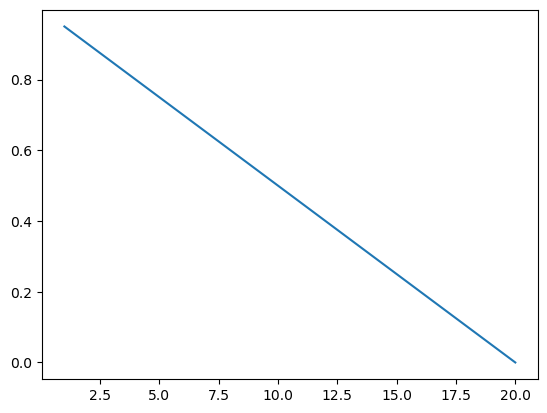

In [329]:
i = np.linspace(1,20, 20)
y = (20-i)/20
plt.plot(i,y)

(array([1000]),)
[0.1930983]
1


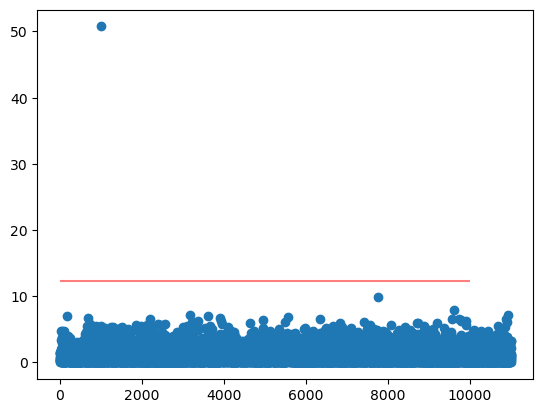

In [406]:
# Simulate population
sample_size = 1000
genome_size = 11_000

envs = np.random.normal(0,0.5, size = sample_size)

effects = np.full(genome_size, 0.8/genome_size)
effects[1000] = effects[1000] + 0.2 

# effects = np.zeros(genome_size)
# effects[1000] = 0.2

# for i in range(20):
#     effects[i*500] = ((20 - i)/20)*2
genos = np.random.choice([0,1,2], size = genome_size*sample_size).reshape(sample_size,genome_size) ## NOT REALISTIC!!!
# P = G + E
phenos = (effects*genos).sum(axis = 1) + envs

# Run GWAS
ps = np.zeros(genome_size)
bs = np.zeros(genome_size)

for i in range(genome_size):
    X = genos[:,i]
    X = sm.add_constant(X) 
    mod = sm.OLS(phenos, X).fit()
    ps[i] = mod.pvalues[1]
    bs[i] = mod.params[1]
    
# Plot Results
plt.scatter(range(genome_size), -np.log(ps))
plt.hlines(-np.log(0.05/genome_size),0,10000,color = 'red', alpha = 0.5)
print(np.where(ps < 0.05/genome_size))
print(bs[np.where(ps < 0.05/genome_size)])
print(len(np.where(ps < 0.05/genome_size)[0]))

In [408]:
F = (2*(genos[:,1000] == 0).sum() + (genos[:,1000] == 0).sum())/20000
B = bs[1000]
(2*F)*(1-F)*(B**2)/np.var(phenos)

0.013430178683838997

In [409]:
X = genos[:,1000]
X = sm.add_constant(X) 
mod = sm.OLS(phenos, X).fit()

In [411]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     101.3
Date:                Sun, 19 May 2024   Prob (F-statistic):           9.06e-23
Time:                        15:27:35   Log-Likelihood:                -728.64
No. Observations:                1000   AIC:                             1461.
Df Residuals:                     998   BIC:                             1471.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8131      0.025     32.990      0.000       0.765       0.861
x1             0.1931      0.019     10.067      0.000       0.155       0.231
==============================================================================
Omnibus:                        6.944   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                5.040
Skew:                          -0.004   Prob(JB):                       0.0805
Kurtosis:                       2.652   Cond. No.                         2.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:ylabel='Density'>

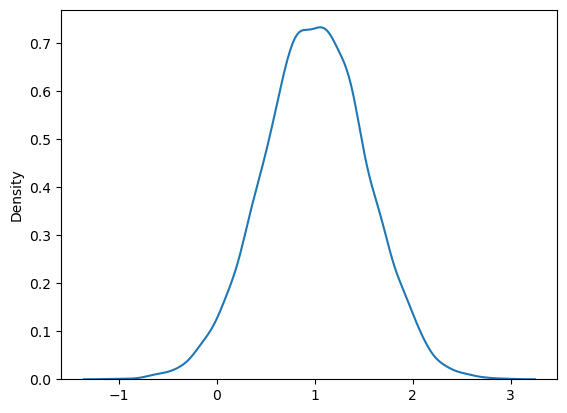

In [388]:
sns.kdeplot(phenos)

/Users/jacobsen/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

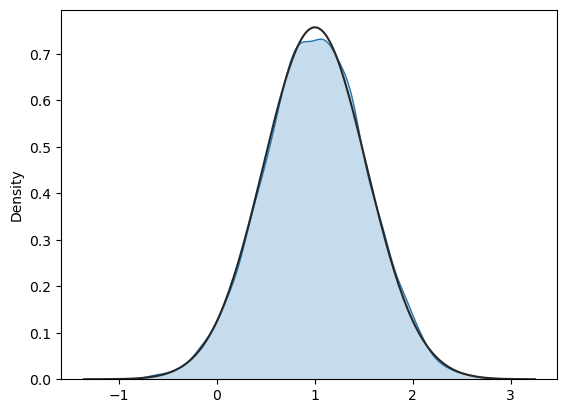

In [389]:
sns.distplot(phenos, hist = False, kde_kws = {"shade" : True, "lw": 1}, fit = stats.norm)

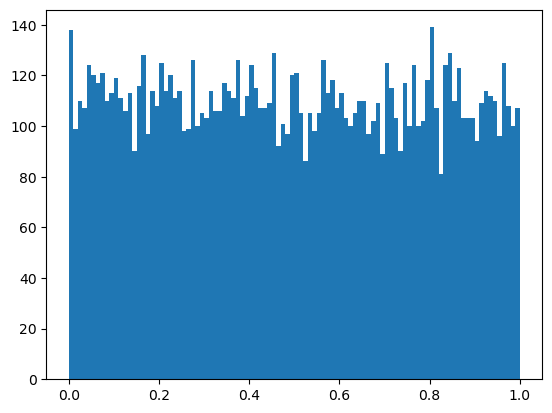

In [374]:
plt.hist(ps, bins = 100);

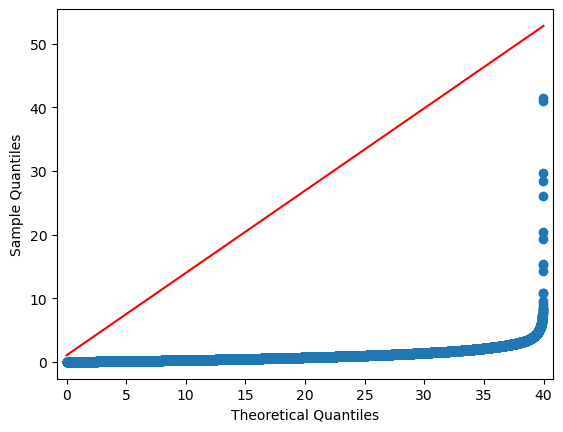

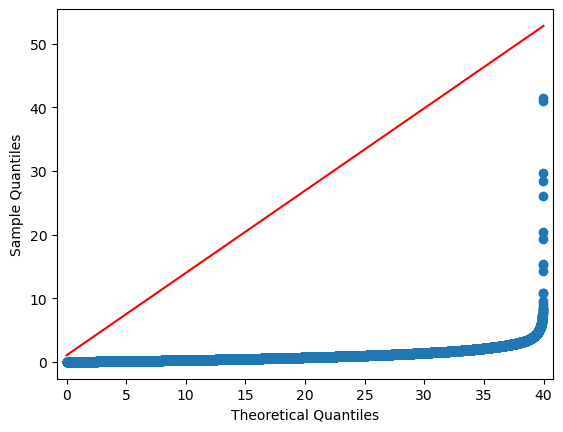

In [377]:
sm.qqplot(-np.log(ps), dist = stats.uniform, scale = 40, line = 's')

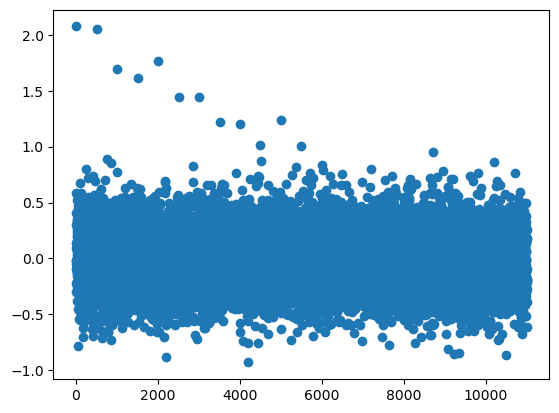

In [379]:
plt.scatter(range(genome_size), (bs))

/var/folders/9p/tdsfbkc524j05kttcf9bm6240000gp/T/ipykernel_25357/3190864821.py:1: RuntimeWarning: divide by zero encountered in log
  plt.scatter(bs,-np.log(ps))


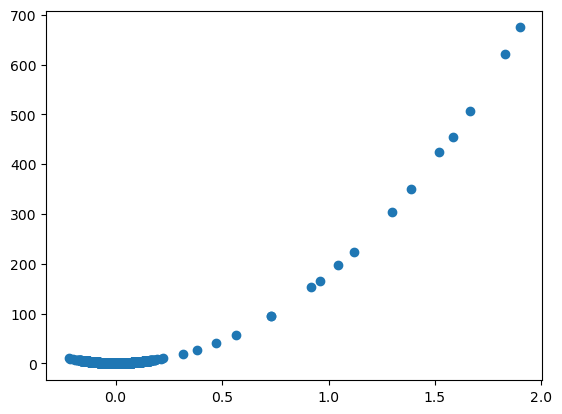

In [381]:
plt.scatter(bs,-np.log(ps))